## Copied from lgm_regrid-LGMR
- This version is for the monthly Amrhein data

In [47]:
#########
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe
import cartopy.crs as ccrs
import copy
import pandas as pd

import pykrige.ok as pyok
from sklearn.metrics.pairwise import haversine_distances
import cartopy.feature as cfeature

In [2]:
## load amrhein data
path = '/home/disk/atmos/vcooper/work/p2c2/lgm/amrhein/'
fname = 'Amrhein18_lgm.nc'
lgm_ds = xr.open_dataset(path + fname)
# lgm_sst = lgm_ds.sst

fname = 'Amrhein18_mod.nc'
holo_ds = xr.open_dataset(path + fname)
# holo_sst = mod_ds.sst

In [3]:
## set lgm_sst_climo to desired file

# lgm_sst_climo = holo_ds
lgm_sst_climo = lgm_ds
lgm_sst_climo['mask'] = xr.where(~np.isnan(lgm_sst_climo.sst[0]), 1, 0)

In [10]:
## got landfrac from the CLM input data namelist
path = '/home/disk/atmos/vcooper/work/ref/'
landfrac = xr.open_dataset(path + 'domain.lnd.fv1.9x2.5_gx1v6.090206.nc')

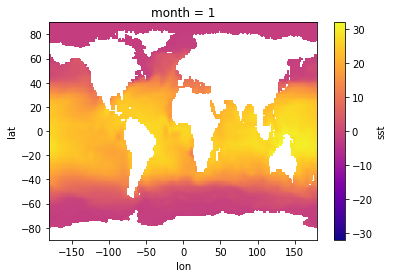

In [4]:
lgm_sst_climo.sst[0].plot(cmap='plasma')

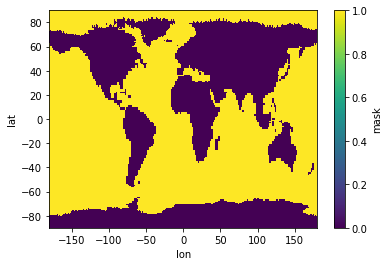

In [5]:
lgm_sst_climo.mask.plot()

In [6]:
# #############
# ## load some data that I just use for reference grids
## this helps identify mask for high lat extrapolation instead of krig

ddir = '/home/disk/atmos/vcooper/work/p2c2/lgm/'
dfile = 'lgmDA_hol_SST_monthly_climo_v2.1.nc'
ncf = ddir + dfile
tempds = xr.open_dataset(ncf)
tempds = tempds.set_coords(['lat','lon','month'])
# tempds = xr.merge([tempds.set_coords(['lat','lon','month','ens']).sst,
#                    tempds.set_coords(['lat','lon','month','ens']).ens])
holo_sst_climo = tempds.assign_coords(month=('nmonth',np.arange(12)+1))
holo_sst_climo['mask'] = xr.where(~np.isnan(holo_sst_climo.sst.isel(nmonth=0)), 1, 0)
dummyds_holo = holo_sst_climo.sst.sel(nmonth=1)

In [7]:
hologrid_frankmask = dummyds_holo / dummyds_holo
temp_mask = hologrid_frankmask.where((hologrid_frankmask.nLon > 0) & 
                 (hologrid_frankmask.nLat < 280) & 
                 (hologrid_frankmask.nLon < 40) | 
                 (hologrid_frankmask.nLon >= 40) & 
                 (hologrid_frankmask.nLon < 140) & 
                 (hologrid_frankmask.nLat < 278) | 
                 (hologrid_frankmask.nLon >= 140) & 
                 (hologrid_frankmask.lat < 69) & 
                 (hologrid_frankmask.nLon < 210) | 
                 (hologrid_frankmask.nLon >= 210) & 
                 (hologrid_frankmask.nLat < 325) & 
                 (hologrid_frankmask.nLon < 293) | 
                 (hologrid_frankmask.nLon >= 293) & 
                 (hologrid_frankmask.lat < 58))
temp_mask = temp_mask.where(temp_mask.nLat > 40)

extrap_mask = xr.where(~np.isnan(temp_mask),0,1)

In [8]:
################
# xesmf regridding of the extrapolation mask
newgrid = lgm_sst_climo # desired grid
newgrid['mask'] = xr.where(lgm_sst_climo.sst[0] > 0, 1, 1)
data_for_regridding = extrap_mask

regridder = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',
                         periodic=True,
                         extrap_method='inverse_dist',
#                          filename='bilinear_margo_to_holo_per_extrapID.nc',
                         reuse_weights=False)
extrap_mask_regrid = regridder(data_for_regridding)

## rounding error correction
extrap_mask_regrid = xr.where(extrap_mask_regrid < .99,0,1)

/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xarray/core/dataarray.py:789: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:534: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


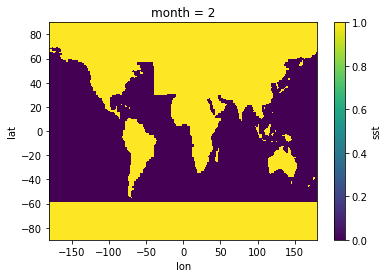

In [9]:
## this is area that will later be extrapolated instead of krigged. matters for high lats
extrap_mask_regrid.plot()
plt.show()

In [17]:
################
# xesmf regridding of the landfrac mask
landfractemp = landfrac.frac.to_dataset().rename({'xc':'lon','yc':'lat'})

newgrid = lgm_sst_climo # desired grid
newgrid['mask'] = xr.where(lgm_sst_climo.sst[0] > 0, 1, 1)
data_for_regridding = landfractemp

regridder = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',
                         periodic=True,
                         extrap_method='inverse_dist',
#                          filename='bilinear_margo_to_holo_per_extrapID.nc',
                         reuse_weights=False)
landfrac_regrid = regridder(data_for_regridding)
landfrac_regrid

/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:567: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Data variables:
    frac     (lat, lon) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  bilinear

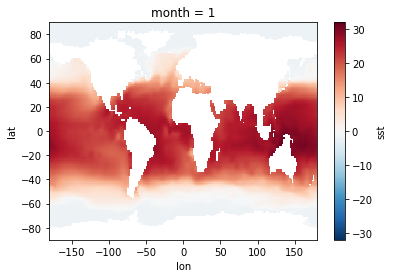

In [24]:
.plot()

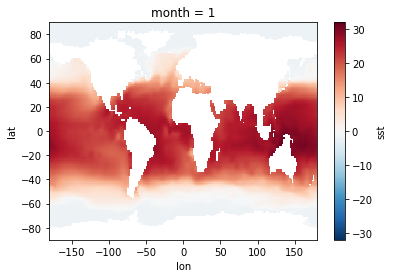

In [41]:
lgm_sst_climo.sst[0].plot()

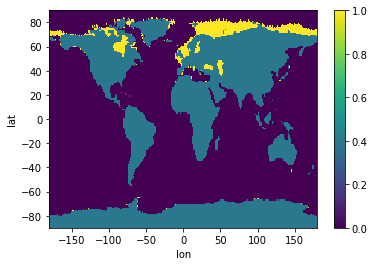

In [55]:
## this is area that will later be extrapolated instead of krigged. matters for high lats
alt_extrap_mask_regrid = xr.where(landfrac_regrid.frac.values<0.5, extrap_mask_regrid, 0.4)
temp = xr.where(np.isnan(lgm_sst_climo.sst[0]), alt_extrap_mask_regrid, 0)
temp = xr.where((np.abs(temp.lat) < 30) & (temp > 0.5), 0.4, temp)
# alt_extrap_mask_regrid = xr.where(np.abs(alt_extrap_mask_regrid.lat) > 30, alt_extrap_mask_regrid, 0.2)

# extrap_mask_regrid.where(
#     landfrac_regrid.frac.values<0.5).plot(cmap='bwr')
# plt.title('extrapolation regions)')
# plt.show()
temp.plot()

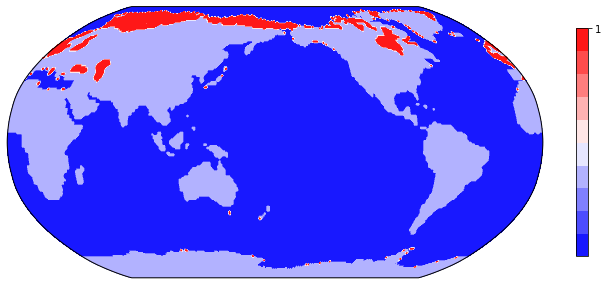

In [56]:
## checking the anomaly pattern before regridding
nlevs = 8*4 ## must be even
vabs = 1
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('bwr', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = temp
## add cyclic point
# lon_idx = ds.dims.index('lon')
# lon = ds.coords['lon']
# wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(ds.lon, ds.lat, ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.contourf(ds.lon, ds.lat, ds,
            cmap = 'bwr', vmin=0,vmax=1,levels=10,
            transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
# axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
# plt.title('lgm prediddle: Month ' + str(isel_m+1))
plt.show()

In [10]:
%%time
## start with single month of SSTs
for msel in range(12):

    ds = lgm_sst_climo.sst[msel]#.sel(nLat=latslice,nLon=lonslice)

    data_all = ds.values.ravel()
    
    ## REGULAR GRID option, on for Amrhein
    llon, llat = np.meshgrid(ds.lon, ds.lat) ## extra lines because of regular grid
    xc = llon.ravel()[~np.isnan(data_all)]
    yc = llat.ravel()[~np.isnan(data_all)]
    all_lons = llon.ravel()
    all_lats = llat.ravel()
    
    ## IRREGULAR GRID option
#     xc = ds.lon.values.ravel()[~np.isnan(data_all)]
#     yc = ds.lat.values.ravel()[~np.isnan(data_all)]
#     all_lons = ds.lon.values.ravel()
#     all_lats = ds.lat.values.ravel()

    data = data_all[~np.isnan(data_all)] ## exclude land for the "obs"
    data_coords = np.moveaxis(np.vstack([yc,xc]),-1,0)
    all_coords = np.moveaxis(np.vstack([all_lats,all_lons]),-1,0)

    ## determine all patch centers
    latstep = 20 ## 25 for MARGO
    clats1 = np.arange(-50,50+1,latstep)
#     print(clats1)
    clats2 = clats1[0:-1]+latstep/2
#     print(' ',clats2)

    lonstep=60 ## 90 for MARGO
    clons1 = np.arange(0,360-lonstep+1,lonstep)
#     print(clons1)
    clons2 = clons1[0:-1]+lonstep/2
#     print(' ',clons2)

    ## initialize dictionary to store kriging results and distances
    krigpatch_dict = {}
    alld_dict = {}

    ## get great circle distance around a patch
    ## set maximum distance for patch based on distance to diagonal patch center
    choose_center_lats = clats1
    choose_center_lons = clons1
    choose_offset_lats = clats2
    choose_offset_lons = clons2

    for i,latval in enumerate(choose_center_lats):
        krigpatch_dict[latval] = {}
        alld_dict[latval] = {}

    #     for j,lonval in enumerate(clons1):
        for j,lonval in enumerate(choose_center_lons):
            cpair = np.hstack([latval,lonval])[np.newaxis,:]
#             print(i, j, cpair)

            i2 = i
            j2 = j
            if i > (len(choose_offset_lats)-1): ## note this only works when doing full loop
                i2 = i-1
            if j > (len(choose_offset_lons)-1):
                j2 = j-1


            cpair_offset = np.hstack([choose_offset_lats[i2],
                                      choose_offset_lons[j2]])[np.newaxis,:]

            alld = haversine_distances(
                np.deg2rad(cpair),np.deg2rad(all_coords)).squeeze() * 6371 #km

            tempd = haversine_distances(
                np.deg2rad(cpair),np.deg2rad(data_coords)).squeeze() * 6371 #km

            maxdist = haversine_distances(
                np.deg2rad(cpair),np.deg2rad(cpair_offset)).squeeze() * 6371 #km

#             print('maxdist = ', np.round(maxdist), 'km')

            data_inside_patch_index = np.where(tempd < maxdist)[0]
#             print('size of patch data: ',data_inside_patch_index.size)

            np.random.seed(1)
            ind = np.random.choice(data_inside_patch_index,
                                   size=np.min([2000,data_inside_patch_index.size]),replace=False)

            ## set points of observations for krig
            lat = data_coords[ind][:,0]
            lon = data_coords[ind][:,1]

            OK = pyok.OrdinaryKriging(
                lon,
                lat,
                data[ind],
                variogram_model="exponential", #spherical
                verbose=False,
                enable_plotting=False,
                coordinates_type="geographic",
            )

            ## set pairs for krig based on distance from central point
            krig_ind = np.where(alld < maxdist)[0]
            krig_lon = all_lons[krig_ind]
            krig_lat = all_lats[krig_ind]

            ## old grid for krig; alternative method
            grid_lon = np.linspace(0, 359, 480)
            grid_lat = np.linspace(-89.9, 89.9, 240)


            ## the actual kriging (slow part)
            field, s2 = OK.execute('points', krig_lon, krig_lat)

            ## reshape result to be on full grid
            field_pairs = np.zeros(all_coords[:,0].shape)
            field_pairs[:] = np.nan
            field_pairs[krig_ind] = field
            field_da = xr.DataArray(field_pairs.reshape(ds.shape),
                                    dims=ds.dims,coords=ds.coords)
            alld_da = xr.DataArray(alld.reshape(ds.shape),
                                    dims=ds.dims,coords=ds.coords)

            krigpatch_dict[latval][lonval] = xr.DataArray(field_pairs.reshape(ds.shape),
                                dims=ds.dims,coords=ds.coords)
            alld_dict[latval][lonval] = xr.DataArray(alld.reshape(ds.shape),
                                dims=ds.dims,coords=ds.coords)

    ## REPEAT PROCESS WITH LATS SWITCHED
    choose_center_lats = clats2
    choose_center_lons = clons2
    choose_offset_lats = clats1
    choose_offset_lons = clons1

    for i,latval in enumerate(choose_center_lats):
        krigpatch_dict[latval] = {}
        alld_dict[latval] = {}

    #     for j,lonval in enumerate(clons1):
        for j,lonval in enumerate(choose_center_lons):
            cpair = np.hstack([latval,lonval])[np.newaxis,:]
#             print(i, j, cpair)

            i2 = i
            j2 = j
            if i > (len(choose_offset_lats)-1): ## note this only works when doing full loop
                i2 = i-1
            if j > (len(choose_offset_lons)-1):
                j2 = j-1


            cpair_offset = np.hstack([choose_offset_lats[i2],
                                      choose_offset_lons[j2]])[np.newaxis,:]

            alld = haversine_distances(
                np.deg2rad(cpair),np.deg2rad(all_coords)).squeeze() * 6371 #km

            tempd = haversine_distances(
                np.deg2rad(cpair),np.deg2rad(data_coords)).squeeze() * 6371 #km

            maxdist = haversine_distances(
                np.deg2rad(cpair),np.deg2rad(cpair_offset)).squeeze() * 6371 #km

#             print('maxdist = ', np.round(maxdist), 'km')

            data_inside_patch_index = np.where(tempd < maxdist)[0]
#             print('size of patch data: ',data_inside_patch_index.size)

            np.random.seed(1)
            ind = np.random.choice(data_inside_patch_index,
                                   size=np.min([2000,data_inside_patch_index.size]),replace=False)

            ## set points of observations for krig
            lat = data_coords[ind][:,0]
            lon = data_coords[ind][:,1]

            OK = pyok.OrdinaryKriging(
                lon,
                lat,
                data[ind],
                variogram_model="exponential", #spherical
                verbose=False,
                enable_plotting=False,
                coordinates_type="geographic",
            )

            ## set pairs for krig based on distance from central point
            krig_ind = np.where(alld < maxdist)[0]
            krig_lon = all_lons[krig_ind]
            krig_lat = all_lats[krig_ind]

            ## old grid for krig; alternative method
            grid_lon = np.linspace(0, 359, 480)
            grid_lat = np.linspace(-89.9, 89.9, 240)


            ## the actual kriging (slow part)
            field, s2 = OK.execute('points', krig_lon, krig_lat)

            ## reshape result to be on full grid
            field_pairs = np.zeros(all_coords[:,0].shape)
            field_pairs[:] = np.nan
            field_pairs[krig_ind] = field
            field_da = xr.DataArray(field_pairs.reshape(ds.shape),
                                    dims=ds.dims,coords=ds.coords)
            alld_da = xr.DataArray(alld.reshape(ds.shape),
                                    dims=ds.dims,coords=ds.coords)

            krigpatch_dict[latval][lonval] = xr.DataArray(field_pairs.reshape(ds.shape),
                                dims=ds.dims,coords=ds.coords)
            alld_dict[latval][lonval] = xr.DataArray(alld.reshape(ds.shape),
                                dims=ds.dims,coords=ds.coords)

    ### Addition for Bering Straight
    addl_cpairs = 0
    addl_cpairs +=1
    latval = 66
    lonval = 192
    krigpatch_dict[latval] = {}
    alld_dict[latval] = {}


    cpair = np.hstack([latval,lonval])[np.newaxis,:]
#     print(i, j, cpair)

    alld = haversine_distances(
        np.deg2rad(cpair),np.deg2rad(all_coords)).squeeze() * 6371 #km

    tempd = haversine_distances(
        np.deg2rad(cpair),np.deg2rad(data_coords)).squeeze() * 6371 #km

    maxdist = 3000 # 4500 for MARGO
#     print('maxdist = ', np.round(maxdist), 'km')

    data_inside_patch_index = np.where(tempd < maxdist)[0]
#     print('size of patch data: ',data_inside_patch_index.size)

    np.random.seed(1)
    ind = np.random.choice(data_inside_patch_index,
                           size=np.min([1200,data_inside_patch_index.size]),replace=False)

    ## set points of observations for krig
    lat = data_coords[ind][:,0]
    lon = data_coords[ind][:,1]

    OK = pyok.OrdinaryKriging(
        lon,
        lat,
        data[ind],
        variogram_model="exponential", #spherical
        verbose=False,
        enable_plotting=False,
        coordinates_type="geographic",
    )

    ## set pairs for krig based on distance from central point
    krig_ind = np.where(alld < maxdist)[0]
    krig_lon = all_lons[krig_ind]
    krig_lat = all_lats[krig_ind]

    ## old grid for krig; alternative method
    grid_lon = np.linspace(0, 359, 480)
    grid_lat = np.linspace(-89.9, 89.9, 240)


    ## the actual kriging (slow part)
    field, s2 = OK.execute('points', krig_lon, krig_lat)

    ## reshape result to be on full grid
    field_pairs = np.zeros(all_coords[:,0].shape)
    field_pairs[:] = np.nan
    field_pairs[krig_ind] = field
    field_da = xr.DataArray(field_pairs.reshape(ds.shape),
                            dims=ds.dims,coords=ds.coords)
    alld_da = xr.DataArray(alld.reshape(ds.shape),
                            dims=ds.dims,coords=ds.coords)

    krigpatch_dict[latval][lonval] = xr.DataArray(field_pairs.reshape(ds.shape),
                        dims=ds.dims,coords=ds.coords)
    alld_dict[latval][lonval] = xr.DataArray(alld.reshape(ds.shape),
                        dims=ds.dims,coords=ds.coords)

    weights = np.zeros(np.append(ds.shape,
                             len(clats1)*len(clats1) + len(clats2)*len(clats2) + addl_cpairs))

    l = 0
    for i,val in alld_dict.items():
        for j,val2 in val.items():
            weights[:,:,l] = 1/(val2+1) * (krigpatch_dict[i][j]/krigpatch_dict[i][j])
            l += 1

    wsum = np.nansum(weights,axis=2)
    wsum[wsum == 0] = np.nan

    frank_weighted = np.zeros(ds.shape)

    l = 0
    for i,val in krigpatch_dict.items():
        for j,da in val.items():
            frank_weighted += np.nan_to_num(da * weights[:,:,l])
            l += 1

    frank_weighted = frank_weighted / wsum
    
    ocean_ind = xr.where(ds > 1e6, 1, 1) ## dummy
    frank_mask = ocean_ind * frank_weighted

    krig_wlgm = xr.where(np.isnan(ds) & ~extrap_mask_regrid,frank_mask.values,ds)

    ## regrid this combo onto holo grid with extrapolation to fill in high lats
    newgrid = lgm_sst_climo.isel(month=1) # desired grid
    newgrid['mask'] = xr.where(newgrid.sst > 0, 1, 1)
    data_for_regridding = krig_wlgm.to_dataset()
    data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.sst),1,0)

    regridder = xe.Regridder(data_for_regridding, newgrid,
                             method='bilinear',
                             periodic=True,extrap_num_src_pnts=64,
                             extrap_method='inverse_dist',
                             filename='bilinear_krigwlgm_to_holo_per_extrapID64amrhein.nc',
                             reuse_weights=True)

    merged = regridder(krig_wlgm).to_dataset()
    merged['mask'] = xr.where(
        ~np.isnan(merged.sst),1,0)

    ## save files
    mstring = str(frank_mask.month.values).zfill(2)
    savepath = '/home/disk/sipn/vcooper/nobackup/lgm/infilled/'
    
    ## SET FILENAME
    fname_merged = 'amrhein_lgm_SST_monthly_climo_merged_' + mstring + '.nc'
    merged.to_netcdf(savepath + fname_merged)
    print('finished saving month ' + mstring)

/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:534: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


finished saving month 01


/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:534: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


finished saving month 02


/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:534: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


finished saving month 03


/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:534: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


finished saving month 04


/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:534: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


finished saving month 05


/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:534: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


finished saving month 06


/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:534: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


finished saving month 07


/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:534: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


finished saving month 08


/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:534: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


finished saving month 09


/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:534: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


finished saving month 10


/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:534: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


finished saving month 11


/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:534: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


finished saving month 12
CPU times: user 1h 28min 5s, sys: 29min 34s, total: 1h 57min 39s
Wall time: 45min 6s


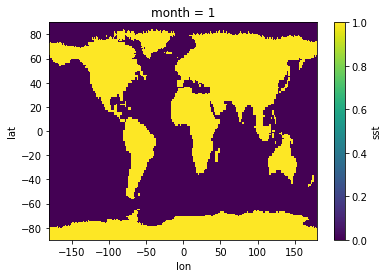

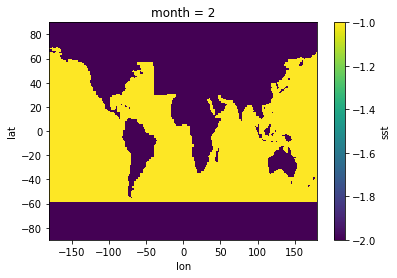

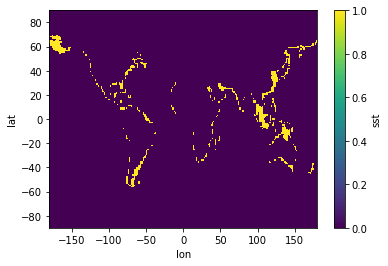

In [21]:
## original mask
(np.isnan(ds)).plot()
plt.show()

## 0 where we want to extrapolate
(~extrap_mask_regrid).plot()
plt.show()

## highlight area that gets krigged but not extrap
(np.isnan(ds) & ~extrap_mask_regrid).plot()
plt.show()

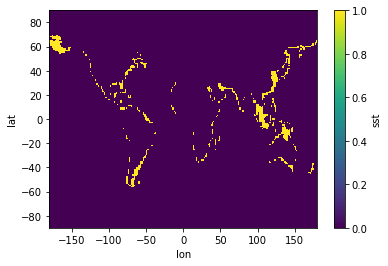

In [59]:
ds = lgm_sst_climo.sst[0]
## highlight area that gets krigged but not extrap
ds = (np.isnan(ds) & ~extrap_mask_regrid)
ds.plot()
plt.show()

/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


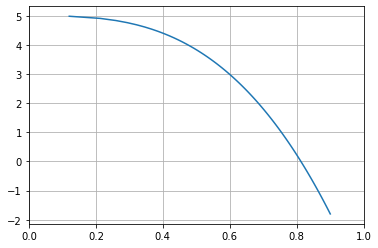

In [67]:
ssttemp = np.linspace(-1.8,5.5,100)
ice_max = (0.729-(ssttemp+1.8)/9.328)**(1./3.)

plt.plot(ice_max,ssttemp)
plt.grid()
plt.xlim(0,1)
plt.show()

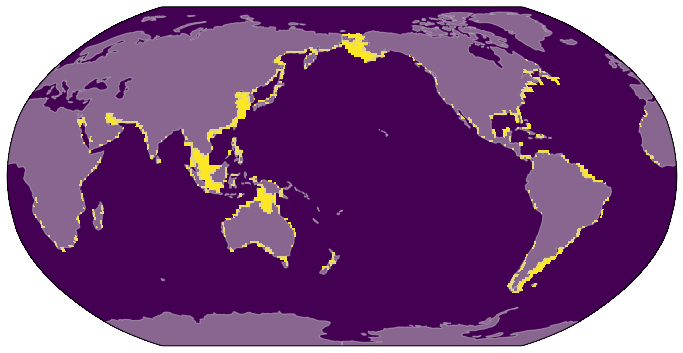

In [63]:
## checking the anomaly pattern before regridding
nlevs = 8*4 ## must be even
vabs = 1
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('bwr', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

# ds = np.isnan(ds) & ~extrap_mask_regrid
## add cyclic point
# lon_idx = ds.dims.index('lon')
# lon = ds.coords['lon']
# wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

plt.pcolormesh(ds.lon, ds.lat, ds,
            cmap = 'viridis', vmin=0,vmax=1,#levels=levs, 
            transform=ccrs.PlateCarree())
# plt.contourf(ds.lon, ds.lat, ds,
#             cmap = 'viridis', vmin=0,vmax=1,levels=10,
#             transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
# plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=0.5,color='0.8',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
# plt.title('lgm prediddle: Month ' + str(isel_m+1))
plt.show()

## Quick results check

In [34]:
import cartopy.feature as cfeature

In [35]:
plotds = merged.sst

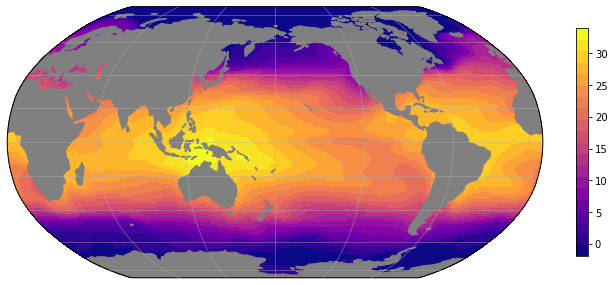

In [38]:
## checking the climo pattern before regridding
fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

plotds = merged.sst
## add cyclic point
# lon_idx = ds.dims.index('lon')
# lon = ds.coords['lon']
# wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

cmap = plt.cm.get_cmap('plasma', 20)
plt.pcolormesh(plotds.lon, plotds.lat, plotds,
            cmap = cmap, vmin=-2,vmax=34,
            transform=ccrs.PlateCarree())
# plt.contourf(ds.lon, ds.lat, ds,
#             cmap = cmap, vmin=-2,vmax=32,
#             transform=ccrs.PlateCarree())

plt.colorbar(shrink=0.6)
# plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
# plt.title('lgm prediddle: Month ' + str(isel_m+1))
plt.show()

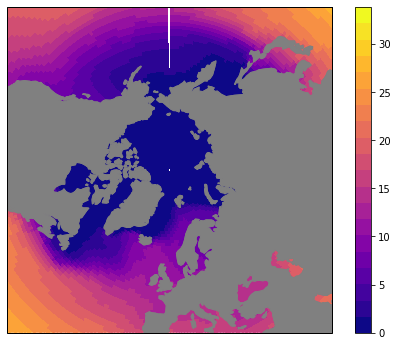

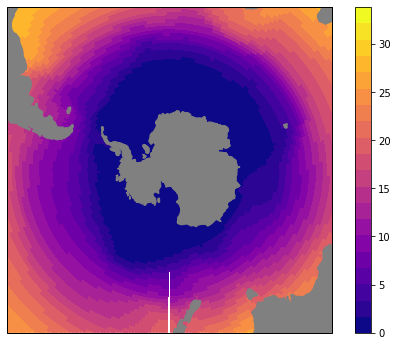

In [40]:
## Arctic
proj = ccrs.NorthPolarStereo()

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, 38, 90], ccrs.PlateCarree())
plt.pcolormesh(plotds.lon,plotds.lat,plotds,
               transform=ccrs.PlateCarree(),vmin=0,
               cmap=cmap,alpha=1)
plt.colorbar()
ax.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
plt.show()

## Antarctic
proj = ccrs.SouthPolarStereo()

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, -38, -90], ccrs.PlateCarree())
plt.pcolormesh(plotds.lon,plotds.lat,plotds,
               transform=ccrs.PlateCarree(),vmin=0,
               cmap=cmap,alpha=1)
plt.colorbar()
ax.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
plt.show()

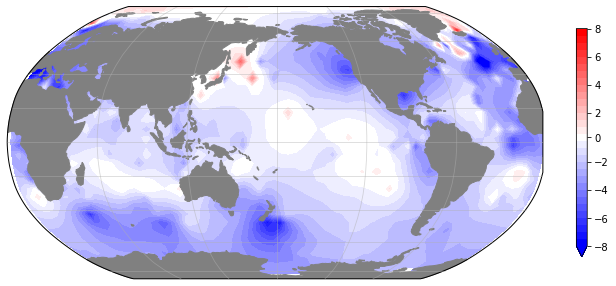

In [74]:
## checking the anomaly pattern before regridding
nlevs = 8*4 ## must be even
vabs = 8
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('bwr', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = merged.sst
## add cyclic point
# lon_idx = ds.dims.index('lon')
# lon = ds.coords['lon']
# wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(ds.lon, ds.lat, ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.contourf(ds.lon, ds.lat, ds,
            cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs, extend='min',
            transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
# plt.title('lgm prediddle: Month ' + str(isel_m+1))
plt.show()

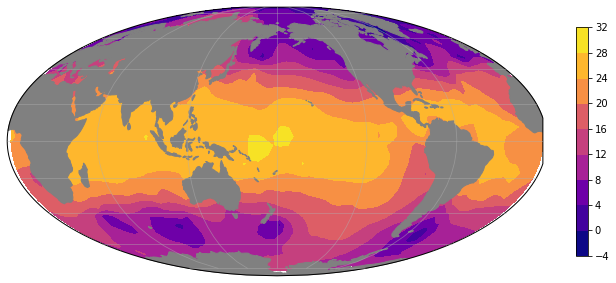

In [83]:
## checking the climo pattern before regridding
fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Mollweide(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = merged.sst
## add cyclic point
# lon_idx = ds.dims.index('lon')
# lon = ds.coords['lon']
# wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

cmap=plt.cm.get_cmap('plasma', 20)
# plt.pcolormesh(ds.lon, ds.lat, ds,
#             cmap = cmap, vmin=-2,vmax=34,
#             transform=ccrs.PlateCarree())
plt.contourf(ds.lon, ds.lat, ds,
            cmap = cmap, vmin=-2,vmax=32,
            transform=ccrs.PlateCarree())

plt.colorbar(shrink=0.6)
# plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
# plt.title('lgm prediddle: Month ' + str(isel_m+1))
plt.show()

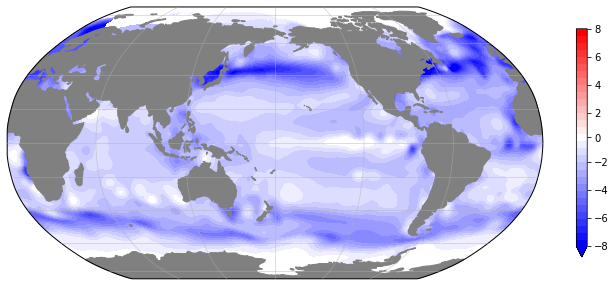

In [15]:
## checking the anomaly pattern before regridding
nlevs = 8*4 ## must be even
vabs = 8
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('bwr', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

plotds = merged.sst
## add cyclic point
# lon_idx = ds.dims.index('lon')
# lon = ds.coords['lon']
# wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(ds.lon, ds.lat, ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.contourf(plotds.lon, plotds.lat, plotds,
            cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs, extend='min',
            transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
# plt.title('lgm prediddle: Month ' + str(isel_m+1))
plt.show()